In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tct
from scipy import optimize
from scipy.cluster.vq import vq, kmeans

## Import with custom python code

In [2]:
metadata, data = tct.read("data/Scan28_1.rtct")
metadata

{'filetype': 82,
 'day': 28,
 'month': 6,
 'year': 2019,
 'hour': 12,
 'minutes': 22,
 'seconds': 7,
 'abstime': 3644562176.0,
 'x0': -18600.50390625,
 'dx': 4.699999809265137,
 'nx': 300,
 'y0': 8150.00048828125,
 'dy': 2.0,
 'ny': 300,
 'z0': 31200.501953125,
 'dz': 1.0,
 'nz': 1,
 'time': datetime.datetime(2019, 6, 28, 12, 22, 7),
 'wfonoff': [1, 1, 0, 0],
 'nu1': 1,
 'u1': array([0.], dtype=float32),
 'nu2': 1,
 'u2': array([0.], dtype=float32),
 't0': 0.0,
 'dt': 4.000000059604645e-10,
 'NP': 1252,
 'T': 0.0,
 'source': 0,
 'user': '',
 'sample': '',
 'comment': ''}

## Manage data with xarray
Can manage only rectangular data (only grid scan, no sparse scan)

In [3]:
import xarray

In [4]:
chs_on = np.argwhere(metadata['wfonoff']).squeeze() + 1
nch = sum(metadata['wfonoff'])
ds = xarray.DataArray(np.stack([data['ch%d' % ch] for ch in chs_on]).reshape(2, metadata['nz'], metadata['ny'], metadata['nx'], metadata['NP']),
                      coords=[chs_on, np.unique(np.sort(data['z'])),
                              np.unique(np.sort(data['y'])),
                              np.unique(np.sort(data['x'])),                              
                              np.arange(0, metadata['NP'] * metadata['dt'], metadata['dt']) / 1E-9], dims=['ch', 'z', 'y', 'x', 'NP'])
ds.coords['NP'].attrs['unit'] = 'ns'

In [5]:
ds.coords

Coordinates:
  * ch       (ch) int64 1 2
  * z        (z) float32 31200.502
  * y        (y) float32 8150.0005 8151.9995 8153.998 ... 8745.999 8748.002
  * x        (x) float32 -18600.5 -18595.502 ... -17199.502 -17194.998
  * NP       (NP) float64 0.0 0.4 0.8 1.2 1.6 ... 498.8 499.2 499.6 500.0 500.4

### Maximum signal

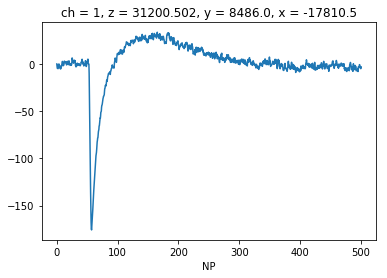

In [6]:
idx_min = np.unravel_index(ds.argmin(), ds.shape)
idx_min = idx_min[:-1]
ds[idx_min].plot()

## Data

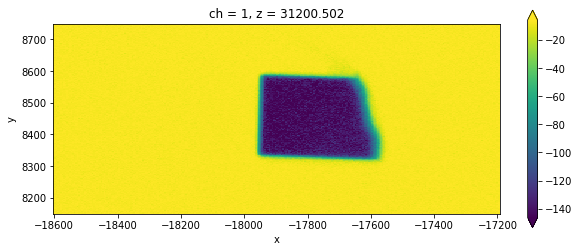

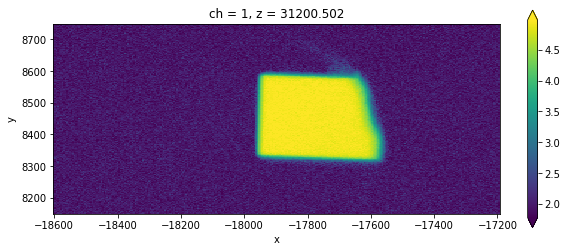

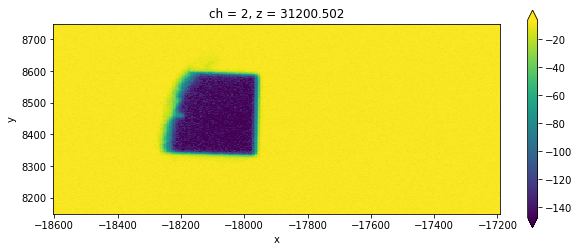

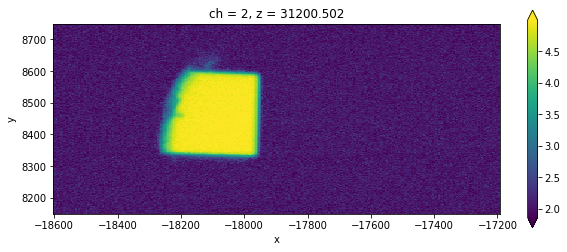

In [7]:
for ch in chs_on:
    fig, ax = plt.subplots(figsize=(10, 4))
    ds.sel(ch=ch).min(dim='NP').plot(robust=True, ax=ax)
    #ax.set_ylim(5100, 5900)
    #ax.set_xlim(-11000, -10150)
    ax.set_aspect('equal')
    fig.savefig('scan2d_linear_ch%d.png' % ch)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    np.log(-ds.sel(ch=ch).min(dim='NP')).plot(ax=ax, robust=True)
#    ax.set_ylim(5100, 5900)
#    ax.set_xlim(-11000, -10150)
    ax.set_aspect('equal')
    fig.savefig('scan2d_log_ch%d.png' % ch)

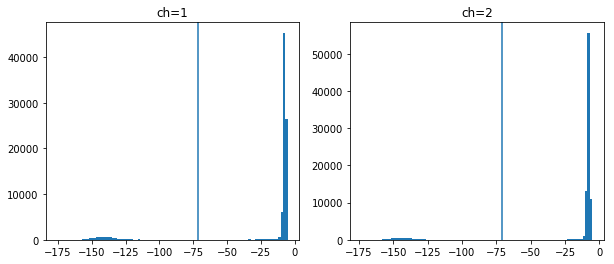

In [9]:
threshoulds_inout = []

fig, axs = plt.subplots(1, nch, figsize=(10, 4))
for ich, ax in enumerate(axs, 1):
    ds.sel(ch=ich).min(dim='NP').plot.hist(bins=100, ax=ax)
    ax.set_title("ch=%d" % ich)
    mins = ds.sel(ch=1).min(dim='NP').values
    mins = mins.reshape([1, np.prod(mins.shape)])
    threshould = np.mean(kmeans(mins.T, 2)[0])
    threshoulds_inout.append(threshould)
    ax.axvline(threshould)

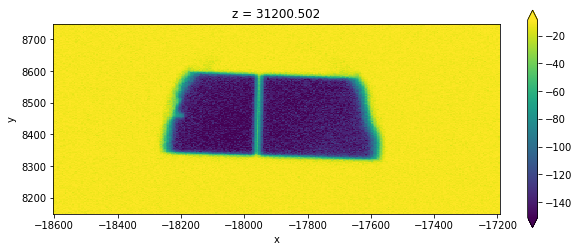

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ds.sum(dim='ch').min(dim='NP').plot(ax=ax, robust=True)
ax.set_aspect('equal')
fig.savefig('scan2d_linear_chsum.png' % ch)

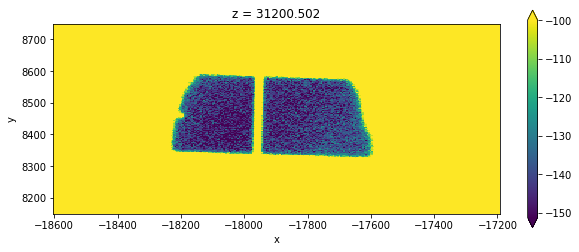

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ds.sum(dim='ch').min(dim='NP').plot(ax=ax, robust=True, vmax=-100)
ax.set_aspect('equal')
#fig.savefig('scan2d_linear_chsum.png' % ch)

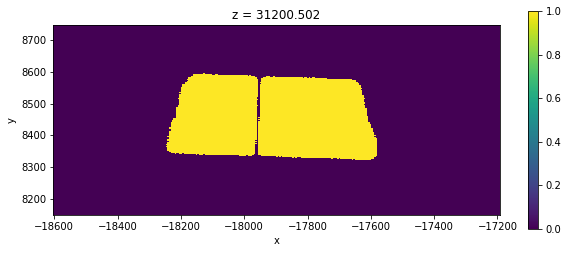

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
t = np.mean(threshoulds_inout)
(ds.sum(dim='ch').min(dim='NP') < t).plot(ax=ax, robust=True)
ax.set_aspect('equal')

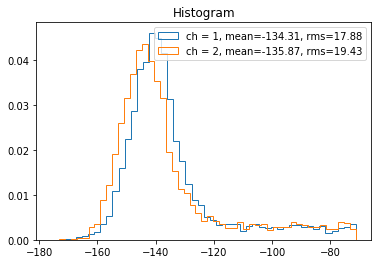

In [13]:
fig, ax = plt.subplots()
for ch in chs_on:
    m = ds.sel(ch=ch).min(dim='NP')
    mm = m.where(m < threshoulds_inout[0])
    mm.plot.hist(bins=50, ax=ax, label='ch = %d, mean=%.2f, rms=%.2f' % (ch, mm.mean(), mm.std()), density=True, histtype='step')
ax.legend()
plt.show()

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


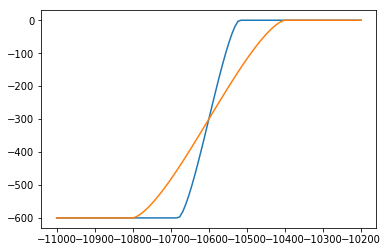

In [11]:
def area_fraction(R, distance):
    distance = np.clip(distance, -R, R)
    sq = np.sqrt(np.clip(R ** 2 - distance ** 2, 0, np.inf))
    area = distance * sq + R ** 2 * np.arctan(distance / sq) + np.pi / 2. * R ** 2
    return area / (np.pi * R ** 2)


def transition_function(x, x0, R, A, C):
    return area_fraction(R, x - x0) * A + C
xx = np.linspace(-11000, -10200, 100)
plt.plot(xx, transition_function(xx, -10600, 80, 600, -600))
plt.plot(xx, transition_function(xx, -10600, 200, 600, -600))

In [9]:
x1_ch2 = -18200
x2_ch2 = -17800
#x1 = mm.x[mm.where(mm < threshoulds_inout[1], drop=True).groupby('y').argmax(dim='x')].max().item()
x1_ch1 = -18000
x2_ch1 = -17800

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[-1.79629232e+04  1.59677152e+01  1.28512772e+02 -1.36607306e+02]
[-1.79509059e+04  1.54831635e+01 -1.31728611e+02 -6.87346208e+00]


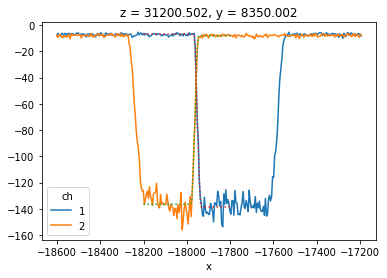

In [13]:

fig, ax = plt.subplots()
d = ds.min(dim='NP').isel(y=100)
d.plot(x='x', hue='ch', ax=ax)

d2 = d.sel(ch=2)

d2 = d2.sel(x = (d2.x > x1_ch2) & (d2.x < x2_ch2))
#d2.plot()

xx = np.linspace(x1_ch2, x2_ch2, 100)
pars = optimize.curve_fit(transition_function, d2.x.data, d2.data[0], p0=[np.mean([x1_ch2, x2_ch2]), 50, 600, -600])[0]
print(pars)
yy = transition_function(xx, *pars)
ax.plot(xx, yy, label='fit', ls=':')



d1 = d.sel(ch=1)
d1 = d1.sel(x = (d1.x > x1_ch1) & (d1.x < x2_ch1))
pars = optimize.curve_fit(transition_function, d1.x.data, d1.data[0], p0=[np.mean([x1_ch1, x2_ch1]), 50, 600, -600])[0]
print(pars)
yy = transition_function(xx, *pars)
ax.plot(xx, yy, label='fit', ls=':')



fig.savefig('intergap.pdf')

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


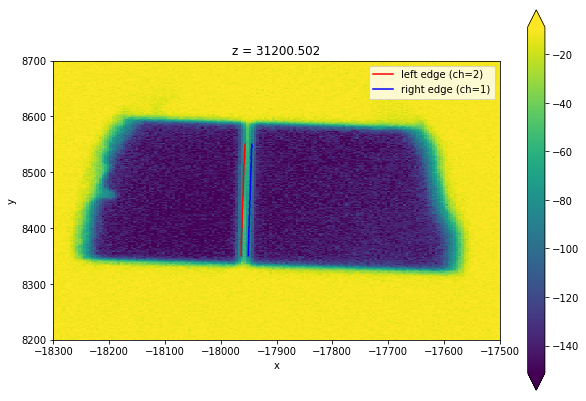

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
ds.sum(dim='ch').min(dim='NP').plot(ax=ax, robust=True)

ds2 = ds.sel(ch=2)
ds2 = ds2.min(dim='NP')
ax.set_ylim(8200, 8700)
ax.set_xlim(-18300, -17500)
ax.set_aspect('equal')

ds_to_fit = ds2.sel(x = ds2.x > x1_ch2).sel(y = (ds2.y > 8350) & (ds2.y < 8550))
xpoints_ch2, ypoints_ch2 = [], []
for y in ds_to_fit.y:
    pars = optimize.curve_fit(transition_function,
                                    ds_to_fit.x.data,
                                    ds_to_fit.sel(y=y).data[0], p0=[np.mean([x1_ch2, x2_ch2]), 50, 600, -600])[0]
    xpoints_ch2.append(pars[0])
    ypoints_ch2.append(y)

ax.plot(xpoints_ch2, ypoints_ch2, 'r', label='left edge (ch=2)')

xpoints_ch1, ypoints_ch1 = [], []
ds1 = ds.sel(ch=1)
ds1 = ds1.min(dim='NP')
ds_to_fit = ds1.sel(x = ds1.x < x2_ch1).sel(y = (ds2.y > 8350) & (ds2.y < 8550))
for y in ds_to_fit.y:
    pars = optimize.curve_fit(transition_function,
                                    ds_to_fit.x.data,
                                    ds_to_fit.sel(y=y).data[0], p0=[np.mean([x1_ch1, x2_ch1]), 65, -573, -16])[0]
    xpoints_ch1.append(pars[0])
    ypoints_ch1.append(y)

ax.plot(xpoints_ch1, ypoints_ch1, 'b', label='right edge (ch=1)')
ax.legend()

fig.savefig('scan_2d.png', bbox_inches='tight')

In [27]:
np.mean(np.array(xpoints_ch1) - np.array(xpoints_ch2)) * 0.2

2.543072430396778

Plot signal shape inside well inside the sensor

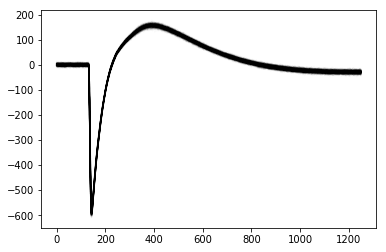

In [24]:
q = ds.sel(ch=1).sel(x = (ds.x > -10500) & (ds.x < -10300)).sel(y = (ds.y > 5500) & (ds.y < 5600))
q = q.data.reshape(q.shape[0] * q.shape[1] * q.shape[2], q.shape[3])
plt.plot(q.T[:,1:200], color='k', alpha=0.02)
plt.show()

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


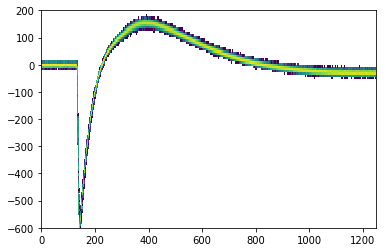

In [27]:
density = np.array([np.histogram(q[:, i], np.linspace(-600, 200, 100))[0] for i in range(q.shape[1])]).T
plt.pcolormesh(np.arange(1252), np.linspace(-600, 200, 100), np.log(density))